# ***Machine Learning Prueba 2 - Analizando los crímenes en la Ciudad de Nueva York***.
### Nombre(s): Thomas Peet, Braulio Águila, Camilo Ramírez
### Generación: G47
### Profesores: Alfonso Tobar - Sebastián Ulloa
### Fecha: 06-10-2022

### *Contexto*
En esta ocasión trabajaremos con datos públicos del departamento de policía de New York.    
El dataset es llamado stop_and_frisk_data y contiene información sobre interrogaciones    
y detenciones realizadas por el departamento de policía de NY en la vía pública. El    
diccionario de atributos se encuentra en el archivo 2009 SQF File Spec.xls.    
Para todo nuestro estudio utilizaremos los datos correspondientes al año 2009 como    
conjunto de entrenamiento y los datos del 2010 como conjunto de pruebas. Hay que hacer    
notar que los datos que estamos utilizando son un muestreo del de la cantidad de registros    
reales que contiene el dataset, esta decisión fue tomada debido a los largos tiempos de    
entrenamiento y procesamiento que requiere el volumen de datos reales. 

### *Objetivos*
Para alcanzar el objetivo general, su trabajo se puede desagregar en los siguientes puntos:  

1. Debe analizar de forma exploratoria los atributos. Reporte la cantidad de datos    
perdidos y presente su esquema de recodificación. Tenga presente que lo que    
observe en el análisis exploratorio debe guiar su proceso de ingeniería de atributos,    
por lo que se le recomienda que piense en aspectos de las variables involucradas     
que puedan afectar el proceso mencionado.

2. Reporte la probabilidad de que un individuo sea arrestado en uno de los cinco  
barrios, condicional al género y a la raza. Concluya, ¿qué implicancias éticas tienen  
algunas conclusiones de lo que observa?.

3. Entregue un modelo predictivo que prediga efectivamente si un determinado  
procedimiento concluirá en un arresto o no. Para ello, guíate por los siguientes  
lineamientos:  
    - Entrene por lo menos 3 modelos que sean capaces de predecir si se  
producirá un arresto o no. Una vez que encuentre un modelo satisfactorio,  
reporte al menos dos métricas de desempeño.  
    - Refine aquellos atributos relevantes con alguna estrategia que crea  
conveniente y reporte por lo menos 5 atributos relevantes para realizar la  
predicción.

4. Genere al menos cinco modelos predictivos que permitan determinar si el  
procedimiento policial concluirá en alguna acción violenta.  
○ Para ello, debe generar un nuevo atributo como vector objetivo que indique  
cuándo hubo violencia o no. Éste debe ser creado a partir de atributos  
existentes que indiquen el tipo de violencia.
  
5. Seleccione los 2 mejores modelos, serialicelos y envíalos a evaluación. Recuerde que  
el modelo serializado debe ser posterior al fit, para poder ejecutar predict en los  
nuevos datos

>>>#### Tipo de problema a resolver:
- De acuerdo con el enunciado y una revisión preliminar de los datos entregados, ambas problemáticas planteadas,  
el hecho de que ocurra o no un arresto, y de que un procedimiento policial es o no violento, corresponden a   
problemas de **clasificación**, ya que ambas variables objetivos son discretas.

>>>#### Tipo de métricas a implementar:
- Las métricas que se utilizarán para la división de muestras corresponden a :
- Tipo de preprocesamiento: 

>>>#### Modelos (5) con gridsearch e hiperparamétros tentativos/definitivos:
- Modelo 1:
- Modelo 2:
- Modelo 3:
- Modelo 4:
- Modelo 5:

>>>#### Comportamiento de variables objetivo (recodificados):
- Variable objetivo 1: procedimiento policial en el que ocurre o no un arresto ("arstmade")
- Variable objetivo 2: procedimiento policial 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from feature_engine.encoding import OrdinalEncoder, OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
#from feature engine drop features ----> sacar features para el pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn import set_config
set_config(display='diagram')

from pathlib import Path
from pandas_profiling import ProfileReport

import geopandas as gpd
import contextily as cx
#import shapely
#import folium 
import pyproj
import helpers as hp
import preproc_nyc_sqf as preproc
import contextily as cx
#pd.set_option('display.max_colwidth', None)
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

## ***Dataset interrogaciones/detenciones Policía de Nueva York - 2009***:

In [2]:
df2009 = pd.read_csv('2009_1perc.csv', index_col=0)
df2009.head(5)

,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,crimsusp,...,zip,addrpct,sector,beat,post,xcoord,ycoord,dettypcm,linecm,detailcm
178048,2009,41,1779,4032009,130,A,O,P,1.0,CPW,...,,41,G,7,,1013067,238633,CM,1,20
498873,2009,108,5805,10292009,1050,A,O,P,3.0,BURG,...,,108,J,,,1012043,212157,CM,1,14
463573,2009,43,8340,10062009,1450,1,O,P,1.0,MISD,...,,43,E,,,1017599,240200,CM,1,20
43626,2009,77,932,1232009,1843,A,O,P,5.0,MIS,...,,77,J,4,35,1002625,183442,CM,1,24
563921,2009,110,11224,12132009,1655,A,O,P,3.0,CPW,...,,110,H,,,1024535,209890,CM,1,20


In [3]:
#Revisión de registros y features de df1:
df2009.shape #5812 registros y 111 features

(5812, 111)

In [4]:
#Se utiliza función entregada para limpieza preliminar de la data, se obtiene un df nuevo procesado y dos listas:
proc_df, suitable_categorical_attributes, suitable_numerical_attributes = preproc.create_suitable_dataframe(df2009)
proc_df #este nuevo dataframe, estas constituido de 69 variables categóricas y 2 númericas sintéticas ("meters", "month")

['perobs', 'xcoord', 'ycoord']


c:\Users\Braulio\Documents\ADL\03_Desafíos y Pruebas\Pruebas\Módulo 3 - ML\Prueba 3\prueba\crimenes\preproc_nyc_sqf.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["xcoord"] = df["xcoord"].apply(lambda x: float(x))
c:\Users\Braulio\Documents\ADL\03_Desafíos y Pruebas\Pruebas\Módulo 3 - ML\Prueba 3\prueba\crimenes\preproc_nyc_sqf.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ycoord"] = df["ycoord"].apply(lambda x: float(x))
c:\Users\Braulio\Documents\ADL\03_Desafíos y Pruebas\Pruebas\Módul

,recstat,inout,trhsloc,typeofid,explnstp,othpers,arstmade,sumissue,offunif,officrid,...,eyecolor,build,city,sector,beat,post,month,meters,xcoord,ycoord
178048,A,O,P,P,Y,N,N,N,Y,N,...,BR,M,BRONX,G,7,,4,1.798320,1013067.0,238633.0
463573,1,O,P,V,Y,N,N,N,N,N,...,BR,M,BRONX,E,U,,10,1.920240,1017599.0,240200.0
43626,A,O,P,P,Y,N,N,N,Y,N,...,BR,T,BROOKLYN,J,4,35,12,1.676400,1002625.0,183442.0
261097,1,I,T,V,Y,N,N,N,N,Y,...,BR,M,MANHATTAN,F,16,,5,1.767840,986061.0,213320.0
538417,1,O,P,P,Y,N,N,N,Y,N,...,BR,T,BROOKLYN,N,U,,11,1.557528,1004543.0,180604.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260095,A,O,P,V,Y,Y,N,N,Y,N,...,BR,M,BRONX,N,U,3,5,1.554480,1018516.0,259880.0
452302,A,O,P,P,Y,N,N,N,N,N,...,BR,T,BROOKLYN,F,17,,9,1.557528,1001545.0,192836.0
310352,1,O,P,P,Y,N,N,N,Y,N,...,BR,M,BROOKLYN,B,U,,6,1.737360,1012860.0,174682.0
132886,1,O,H,P,Y,N,Y,N,Y,N,...,BR,T,BROOKLYN,A,10,,3,1.767840,981820.0,185424.0


>>>#### Exploración variable objetivo 1 ("arstmade")

In [7]:
proc_df.arstmade.value_counts() #oversampling

N    4223
Y     276
Name: arstmade, dtype: int64

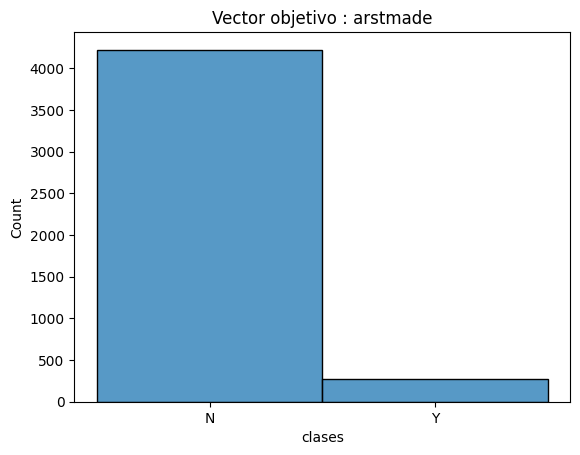

In [8]:
#Visualización de el vector objetivo:
sns.histplot(proc_df, x="arstmade"); # Categoría uno muchos menos casos que categoría 0.
plt.title("Vector objetivo : arstmade")
plt.xlabel("clases");

>>>#### Exploración variable objetivo 2 ("violencia física en arresto") --- Necesita ser recodificada

In [9]:
#Recodificando variable objetivo 2:

var_pf = proc_df.columns[np.where([i[0:2]=='pf' for i in proc_df.columns.tolist()])]. tolist()
u = proc_df[var_pf]
u["var_pf"] = [np.isin(["Y"], u.iloc[i].values.tolist())[0] for i in range(0,len(u))]
proc_df.insert(proc_df.shape[1],"var_pf", u["var_pf"])
proc_df


C:\Users\Braulio\AppData\Local\Temp\ipykernel_11140\1169417975.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u["var_pf"] = [np.isin(["Y"], u.iloc[i].values.tolist())[0] for i in range(0,len(u))]


,recstat,inout,trhsloc,typeofid,explnstp,othpers,arstmade,sumissue,offunif,officrid,...,build,city,sector,beat,post,month,meters,xcoord,ycoord,var_pf
178048,A,O,P,P,Y,N,N,N,Y,N,...,M,BRONX,G,7,,4,1.798320,1013067.0,238633.0,False
463573,1,O,P,V,Y,N,N,N,N,N,...,M,BRONX,E,U,,10,1.920240,1017599.0,240200.0,False
43626,A,O,P,P,Y,N,N,N,Y,N,...,T,BROOKLYN,J,4,35,12,1.676400,1002625.0,183442.0,False
261097,1,I,T,V,Y,N,N,N,N,Y,...,M,MANHATTAN,F,16,,5,1.767840,986061.0,213320.0,False
538417,1,O,P,P,Y,N,N,N,Y,N,...,T,BROOKLYN,N,U,,11,1.557528,1004543.0,180604.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260095,A,O,P,V,Y,Y,N,N,Y,N,...,M,BRONX,N,U,3,5,1.554480,1018516.0,259880.0,True
452302,A,O,P,P,Y,N,N,N,N,N,...,T,BROOKLYN,F,17,,9,1.557528,1001545.0,192836.0,True
310352,1,O,P,P,Y,N,N,N,Y,N,...,M,BROOKLYN,B,U,,6,1.737360,1012860.0,174682.0,False
132886,1,O,H,P,Y,N,Y,N,Y,N,...,T,BROOKLYN,A,10,,3,1.767840,981820.0,185424.0,True


In [11]:
hp.cat_num_rate_analysis(proc_df)

,num_to_cat_rate,len of unique,len of data,col type,unique of col
ycoord,0.807735,3634,4499,float64,"[238633.0, 240200.0, 183442.0, 213320.0, 180604.0, 251332.0, 180773.0, 191479.0, 149718.0, 239499.0, 195482.0, 229118.0, 212883.0, 236757.0, 17022..."
xcoord,0.794621,3575,4499,float64,"[1013067.0, 1017599.0, 1002625.0, 986061.0, 1004543.0, 1002850.0, 1004742.0, 1050500.0, 994961.0, 999539.0, 999705.0, 998622.0, 986848.0, 1021080...."
post,0.018004,81,4499,object,"[ , 35, 40, 41, 16, 6, 39, 14, 52, 33, 20, 67, 1, 91, 55, 50, 26, 18, 17, 12, 13, 28, 32, 25, 44, 8, 9, 10, 4, 61, 15, 36, 45, 29, 27, 19, 47, 2, ..."
beat,0.00689,31,4499,object,"[7, U, 4, 16, 1, 2, 9, 11, 13, 15, 5, 3, 6, 25, 24, 8, 14, 21, 62, 10, 18, 22, 12, 17, 61, 20, 19, 32, 41, 23, 42]"
meters,0.005779,26,4499,float64,"[1.7983200000000001, 1.92024, 1.6764000000000001, 1.76784, 1.5575280000000002, 1.85928, 1.5544799999999999, 1.8288000000000002, 1.7373600000000002..."
sector,0.004001,18,4499,object,"[G, E, J, F, N, B, C, A, H, P, D, M, I, U, T, K, Q, R]"
month,0.002667,12,4499,int64,"[4, 10, 12, 5, 11, 3, 8, 9, 7, 2, 1, 6]"
haircolr,0.002445,11,4499,object,"[BK, BR, BA, SP, BL, ZZ, XX, GY, RA, DY, SN]"
eyecolor,0.002223,10,4499,object,"[BR, GR, BK, DF, HA, BL, XX, Z, GY, MA]"
race,0.001778,8,4499,object,"[B, Q, W, Z, P, A, U, I]"


In [ ]:
#redinir variable "othpers" (esta mál escrita con respecto a la planilla)
mantener = ["var_pf", "rf_vcrim", "rf_othsw	", "rf_attir", "cs_descr", "arstmade"	]
var_eliminar_pf = ["pf_baton", "pf_hcuff", "pf_pepsp", "pf_other", "pf_ptwep", 
                    "pf_drwep", "pf_wall", "pf_hands", "pf_grnd"] #9 variables eliminadas
var_eliminar_others = ["ac_rept", "ac_inves", "ac_proxm	", "cs_casng", "cs_lkout", "explnstp", "sumissue"]
pendientes = ["radio", "cs_objcs", "inout", "othpers"]


In [ ]:
#Eliminar variables (Considerar drop_features)
#dropna(axis = 1, inplace= True)
#df_na = df1.dropna(how="all", axis=1)  
#dfnan = df1.dropna(subset=["ID"])

In [21]:
#Formato para definir variables elegidas posterior al filtro

# # ***Listado de variables***:
# * `age`: Edad del individuo.
# * `workclass`: Naturaleza de la organización que emplea al individuo.
# * `education`: Nivel educacional del individuo:
#     | Variable          | Explicación                       |
#     | ----------------- | ------------------                |
#     | __Bachelors__     | (Licenciado)                      |
#     | __Some-college__  | (Superior incompleta)             |
#     | __11th__          | (3ro medio)                       |
#     | __HS-grad__       | (Secundaria completa)             |
#     | __Prof-school__   | (Escuela profesional)             |
#     | __ssoc-acdm__     | (Técnico superior administrativo) |
#     | __Assoc-voc__     | (Técnico superior vocacional)     |
#     | __9th__           | (1ro medio)                       |
#     | __7th-8th__       | (7mo-8vo)                         |
#     | __12th__          | (4to medio)                       |
#     | __Masters__       | (Maestría de postgrado)           |
#     | __1st-4th__       | (1ro-4to básico)                  |
#     | __10th__          | (2do medio)                       |
#     | __Doctorate__     | (Doctorado)                       |
#     | __5th-6th__       | (5to-6to)                         |
#     | __Preschool__     | (Preescolar).                     |
     
#     <br>  
    
# * `capital-gains`: Ingresos generados por inversiones fuera del trabajo asalariado
# * `capital-losses`: Pérdidas generadas por inversiones fuera del trabajo asalariado.
# * `fnlwgt`: Ponderador muestral.
# * `marital-status`: Estado civil del individuo: 

<AxesSubplot:>

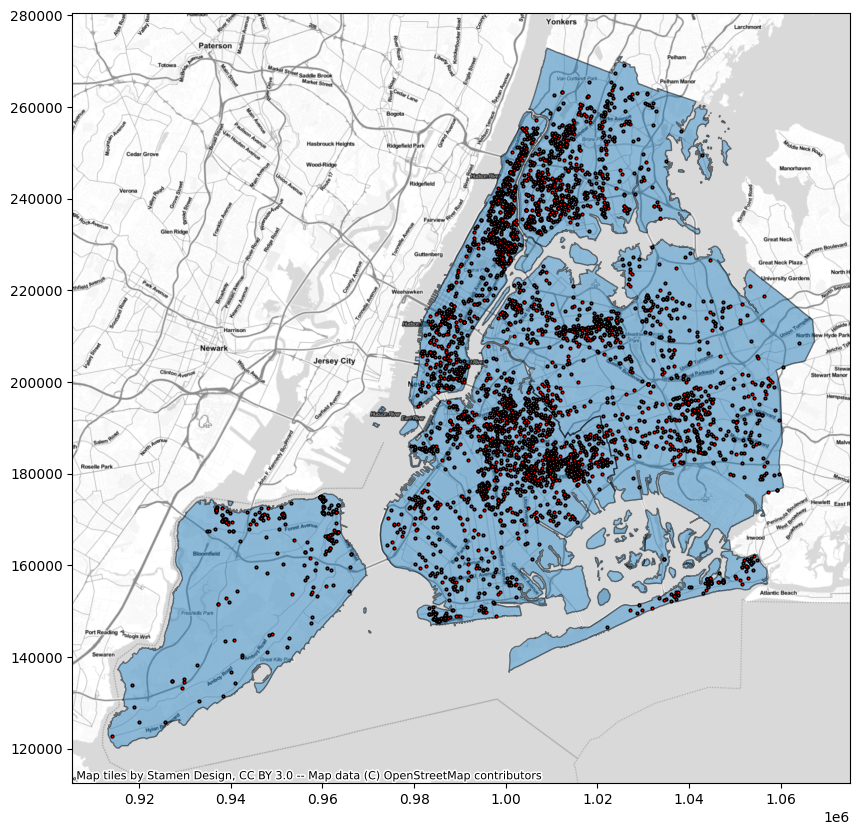

In [18]:
# Mapa
gdf = gpd.GeoDataFrame(proc_df, geometry=gpd.points_from_xy(proc_df.xcoord, proc_df.ycoord))
df = gpd.read_file(gpd.datasets.get_path("nybb"))
df_wm = df.to_crs(epsg=3857)
ax = df.plot(figsize=(15,10), alpha=0.5, edgecolor = "k")
cx.add_basemap(ax,crs=df.crs, zoom =12, source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)
gdf.plot(ax=ax, color= "red", edgecolor = "black", markersize = 4)


#Incorporar en código de arriba para poder plotear variable objetivo:
# fig,ax = plt.subplots(1, 1) #plt.figure(figsize=(10,8))
# fig.set_size_inches(25, 25)
# df2009map[df2009map.arstmade == "N"].plot(color="red", ax=ax, markersize = 1)
# df2009map[df2009map.arstmade == "Y"].plot(ax=ax,  markersize = 12)
# plt.show()

In [19]:
# función transformar x,y to lon, lat:
# def xy_to_latlon(x,y):
#     source_crs = 'epsg:2263' # Coordinate system of the file
#     target_crs = 'epsg:4326' # Global lat-lon coordinate system
#     polar_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)
#     lat, lon = polar_to_latlon.transform(x,y)
#     return lon, lat

In [20]:
#otra opción de crear mapa con folium:
# def generateBaseMap(loc, zoom=11, tiles='OpenStreetMap', crs='ESPG3857'):
#     return folium.Map(location=loc,
#                    #control_scale=True, 
#                    zoom_start=zoom,
#                    #tiles=tiles)
#     )
# base_map = generateBaseMap([40.7127837, -74.0059413])


# marker = list(range(len(df2009.xcoord)))
# counter = 0
# tooltip = "Click Here For More Info"
# icon = folium.features.CustomIcon('https://cdn-icons-png.flaticon.com/128/7500/7500224.png', icon_size=(40, 40))

# for x,y in zip(df2009.xcoord, df2009.ycoord):
#     lon, lat = xy_to_latlon(x,y)
#     marker[counter] = folium.Marker(icon=icon,
#     #     #location=[40.7127837, -74.0059413],
#     location=[lon, lat],
#     #     #popup="<stong>Allianz Arena</stong>",
#     #     #tooltip=tooltip
#     )
#     marker[counter].add_to(base_map)
#     #print(f"latitud {lat} y longitud {lon}")
#     if counter>5 : 
#         break
#     counter += 1
# base_map

In [23]:
#Conteo de nulos
#proc_df.info(verbose=True, show_counts=True,memory_usage=False)

In [24]:
#Descripción de variables númericas:
proc_df.describe().T

,count,mean,std,min,25%,50%,75%,max
month,4499.0,6.995555e+00,3.317359,1.0000,4.00000,7.000000e+00,1.000000e+01,1.200000e+01
meters,4499.0,1.720603e+00,0.113737,0.9144,1.61544,1.737360e+00,1.798320e+00,2.167128e+00
xcoord,4499.0,1.006263e+06,20912.829229,914102.0000,996823.50000,1.005279e+06,1.016505e+06,1.063894e+06
ycoord,4499.0,2.044132e+05,28465.914236,122790.0000,183062.00000,1.985080e+05,2.306090e+05,2.691170e+05


In [25]:
#Descripción de variables categóricas: (ver posibilidad de usar Pandas profilling)
proc_df.describe(include="O").T


,count,unique,top,freq
recstat,4499,2,A,2830
inout,4499,2,O,3378
trhsloc,4499,4,P,3184
typeofid,4499,4,P,2710
explnstp,4499,2,Y,4497
...,...,...,...,...
build,4499,5,M,2841
city,4499,5,BROOKLYN,1559
sector,4499,18,G,470
beat,4499,31,U,2798


In [26]:
#cargar df2010
# df2 = pd.read_csv('2010_1perc.csv', index_col='Unnamed: 0')
# df2.head()